In [1]:
import numpy as np

from sklearn.datasets import load_digits

from time import time

from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt


In [2]:
# This dataset contains handwritten digits from 0 to 9
# 이미지의 손글씨 숫자가 동일하도록 이미지를 그룹화 한다. 
data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


In [3]:
# 알고리즘의 성능을 평가하고, 다양한 메트릭을 통해 그 성능을 정량적으로 표현한다. 
def bench_k_means(kmeans, name, data, labels):
    """
    Parameters
    ----------
    kmeans : KMeans instance
    name : str
    data : ndarray of shape (n_samples, n_features)
    labels : ndarray of shape (n_samples,)
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    # 시간 계산 
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # 클러스터링 평가 메트릭 계산
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # silhouette_score: 
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [4]:
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette


In [5]:
# k-means++ 초기화 방식: 클러스터 중심을 똑똑하게 선택하여 알고리즘의 수렴을 빠르게 하고 결과를 개선할 수 있다.
# k-means++ 초기화 방식을 사용하여 KMeans 인스턴스를 생성한다. 
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

# 무작위 초기화를 사용한 KMeans 클러스터링
kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

# PCA 기반 초기화를 사용한 KMeans 클러스터링
pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * "_")

k-means++	0.535s	69545	0.598	0.645	0.621	0.469	0.617	0.158
random   	0.144s	69735	0.681	0.723	0.701	0.574	0.698	0.198
PCA-based	0.113s	72686	0.636	0.658	0.647	0.521	0.643	0.143
__________________________________________________________________________________


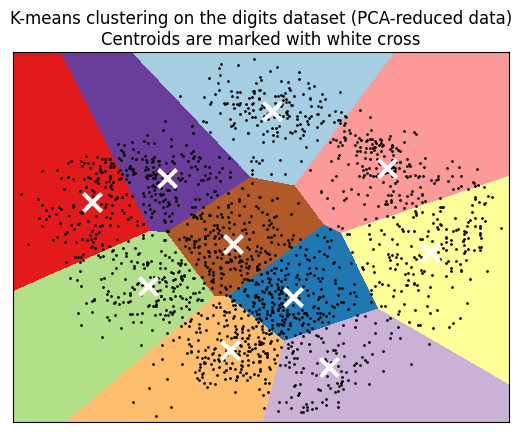

In [6]:
# PCA로 차원 축소된 데이터에 대해 KMeans 클러스터링을 수행하고, 클러스터링 결과와 클러스터 중심을 시각화하는 과정을 설명한다. 
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)

centroids = kmeans.cluster_centers_

# KMeans 클러스터링의 중심(센트로이드)를 흰색 X로 표시
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()